In [1]:

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# import os
import glob
import numpy as np
import cv2

In [3]:
base_path =r'C:\Users\Tanish Garg\.cache\kagglehub\datasets\sanikatiwarekar\deep-fake-detection-dfd-entire-original-dataset'
fake_videos_path = os.path.join(base_path, 'DFD_manipulated_sequences')
real_videos_path = os.path.join(base_path, 'DFD_original sequences')

In [4]:
def extract_frames(video_path, num_frames=10):
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (224, 224))
            frames.append(frame)
    
    cap.release()
    return np.array(frames)

In [5]:
def load_data(video_dir, label, num_videos=50, frames_per_video=10):
    video_paths = glob.glob(os.path.join(video_dir, '*.mp4'))
    data = []
    labels = []
    
    for video_path in tqdm(video_paths[:num_videos], desc=f"Processing {label} videos"):
        frames = extract_frames(video_path, frames_per_video)
        data.extend(frames)
        labels.extend([label] * len(frames))
    
    return np.array(data), np.array(labels)

In [6]:
X_fake, y_fake = load_data(fake_videos_path, 1)
X_real, y_real = load_data(real_videos_path, 0)

# Combine and shuffle data
X = np.concatenate((X_fake, X_real), axis=0)
y = np.concatenate((y_fake, y_real), axis=0)

# Shuffle the dataset
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

Processing 1 videos:   0%|          | 0/50 [00:00<?, ?it/s]

Processing 0 videos:   0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=16)
val_generator = val_datagen.flow(X_val, y_val, batch_size=16)

In [10]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

In [11]:
def create_efficientnetb7_model(input_shape=(224, 224, 3)):
    base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_efficientnetb7_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)          │ (None, 7, 7, 2560)          │      64,097,687 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2560)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,753,560 (247.02 MB)

 Trainable params: 655,873 (2.50 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
import glob
from tqdm.notebook import tqdm

C:\Users\Tanish Garg\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 817s 14s/step - accuracy: 0.5421 - loss: 0.6913 - val_accuracy: 0.4200 - val_loss: 0.7878
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 664s 13s/step - accuracy: 0.7065 - loss: 0.5650 - val_accuracy: 0.4200 - val_loss: 1.0562
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 687s 14s/step - accuracy: 0.7854 - loss: 0.4752 - val_accuracy: 0.4200 - val_loss: 0.9839
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 667s 13s/step - accuracy: 0.8087 - loss: 0.4370 - val_accuracy: 0.4200 - val_loss: 1.2588
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 659s 13s/step - accuracy: 0.8046 - loss: 0.4100 - val_accuracy: 0.4200 - val_loss: 1.1416
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 661s 13s/step - accuracy: 0.8356 - loss: 0.3672 - val_accuracy: 0.4200 - val_loss: 1.5006
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.4080 - loss: 0.7948
Validation Accuracy: 0.42


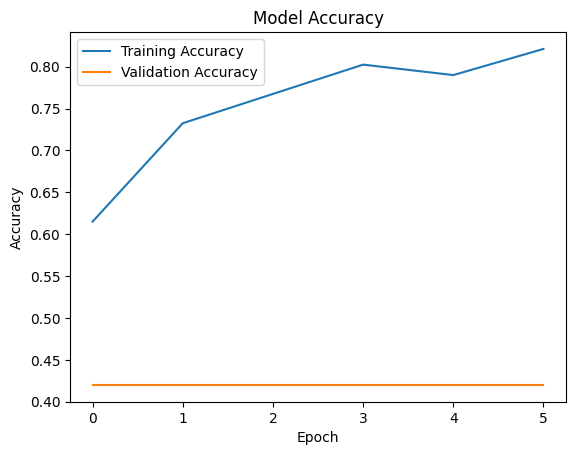

In [13]:
# Unfreeze some layers of the base model for fine-tuning
def create_finetuned_efficientnetb7_model(input_shape=(224, 224, 3)):
    base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Unfreeze the last few layers for fine-tuning
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.4),  # Adjusted dropout
        Dense(512, activation='relu'),  # Increased layer size
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_finetuned_efficientnetb7_model()

# Enhanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Increased rotation
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=16)
val_generator = val_datagen.flow(X_val, y_val, batch_size=16)

# Train the model with fine-tuning
history = model.fit(
    train_generator,
    epochs=20,  # Increased epochs
    validation_data=val_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('efficientnetb7_deepfake_finetuned.keras', save_best_only=True)
    ]
)

# Evaluate the updated model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
def create_finetuned_model(input_shape=(224, 224, 3)):
    base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True  # Fine-tune more layers

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_finetuned_model()

# Re-train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('efficientnetb7_deepfake_finetuned.keras', save_best_only=True)
    ]
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 828s 14s/step - accuracy: 0.4412 - loss: 0.7254 - val_accuracy: 0.4200 - val_loss: 0.7083
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 668s 13s/step - accuracy: 0.5193 - loss: 0.7097 - val_accuracy: 0.4200 - val_loss: 0.7793
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 666s 13s/step - accuracy: 0.5882 - loss: 0.6763 - val_accuracy: 0.4200 - val_loss: 0.7431
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 658s 13s/step - accuracy: 0.5738 - loss: 0.6742 - val_accuracy: 0.4200 - val_loss: 0.7763
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 669s 13s/step - accuracy: 0.6269 - loss: 0.6481 - val_accuracy: 0.4200 - val_loss: 0.7704
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 677s 14s/step - accuracy: 0.6783 - loss: 0.6188 - val_accuracy: 0.4200 - val_loss: 0.7539


In [15]:
# Retrieve training and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Print the final epoch's accuracy
print(f"Final Training Accuracy: {train_accuracy[-1]:.2f}")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.2f}")

Final Training Accuracy: 0.65
Final Validation Accuracy: 0.42


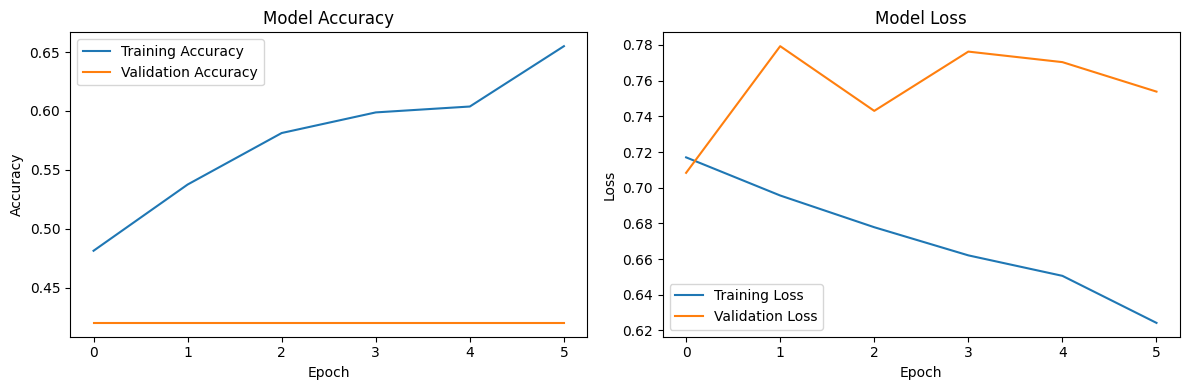

In [16]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
def predict_video(video_path, model, num_frames=20):
    frames = extract_frames(video_path, num_frames=num_frames)
    frames = frames / 255.0  # Normalize
    predictions = model.predict(frames)
    avg_prediction = np.mean(predictions)
    
    return avg_prediction > 0.5, avg_prediction

# Test on a sample video
sample_video_path = '/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences/01_04__kitchen_still__GBC7ZGDP.mp4'  # Replace with the actual path
is_manipulated, confidence = predict_video(sample_video_path, model)

if is_manipulated:
    print(f"The video is predicted to be a deepfake with {confidence * 100:.2f}% confidence.")
else:
    print(f"The video is predicted to be original with {(1 - confidence) * 100:.2f}% confidence.")

C:\Users\Tanish Garg\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


ValueError: math domain error

In [ ]:
# Save the model in the Keras format
model.save('deepfake_detector.keras')